# Wrangle and Analyze Data

## Introduction
The purpose of this project is to wrangle and analyze data from WeRateDogs, a humorous Twitter account that rates dog photos. I will gather data from various sources, in several formats, assess the quality of the data, clean it, and then provide analysis. 

From the course **Project Details**, the tasks to accomplish are:
- Data wrangling, which consists of:
 - Gathering data
 - Assessing data
 - Cleaning data
- Storing, analyzing, and visualizing your wrangled data
- Reporting on 1) your data wrangling efforts and 2) your data analyses and visualizations

#### Imports
Import libraries as dictacted by project description.

In [229]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import tweepy
import requests as rq
import time
import json

pd.set_option('display.max_colwidth', 30)

## Gathering Data
#### Open DogRates Twitter Archive with *Pandas*
This file was provided as-is. Open *twitter-archive-enhanced.csv* with Pandas.

In [179]:
# Specific Dtypes for columns and date columns to parse
archive_dtypes = {'tweet_id':str, 'in_reply_to_status_id': str, 'in_reply_to_user_id': str,
                  'retweeted_status_id': str, 'retweeted_status_user_id': str, 'rating_numerator': int,
                  'rating_denomenator': int}
archive_parse_dates = ['timestamp', 'retweeted_status_timestamp']

archive_df = pd.read_csv('twitter-archive-enhanced.csv', dtype=archive_dtypes, parse_dates=archive_parse_dates)
archive_df.set_index('tweet_id', inplace=True)

#### Get Tweets with *Tweepy*
Download the detailed tweet data from Twitter using Tweepy. Save the data to *tweet_json.txt* once downloaded.

If the file exists, open it locally to avoid redownloading. (The download takes approximately 30 minutes to complete due to API rate-limiting because extended tweets are not supported by the Tweepy bulk-download function.)

In [3]:
retry_count = 0

while True:
    try:
        # open tweet detailed tweet archive file saved locally
        with open('tweet_json.txt', 'r') as fr:
            tweets_df = pd.io.json.json_normalize(
                        json.load(fr)
                     )
        break
    
    except FileNotFoundError as e:
        # list of tweets to download from the archive file
        tweet_ids = archive_df.tweet_id.unique().tolist()
        tweets = []

        for t in tweet_ids:
            try:
                # Parsing Tweepy objects: https://stackoverflow.com/questions/27900451
                
                twitter_keys = {"ConsumerAPIKey":None,
                                "ConsumerSecret":None,
                                "AccessToken":None,
                                "AccessTokenSecret":None}
                # comment this out and insert values to twitter_keys above if using other Twitter API keys
                twitter_keys = pd.read_json('twitterkeys.json', typ='series')
                
                twitter_auth = tweepy.OAuthHandler(twitter_keys['ConsumerAPIKey'], twitter_keys['ConsumerSecret'])
                twitter_auth.set_access_token(twitter_keys['AccessToken'], twitter_keys['AccessTokenSecret'])
                twitter = tweepy.API(twitter_auth, parser=tweepy.parsers.JSONParser(),
                                     wait_on_rate_limit=True,
                                     wait_on_rate_limit_notify=True)

                # get tweets one-by-one because tweepy.statuses_lookup doesn't support tweet_mode=extended
                tweets.append(
                    twitter.get_status(t, tweet_mode='extended', include_entities=True, trim_user=True)
                )

            except tweepy.TweepError as te:
                #swallow 'status not found' errors, raise all others
                if(te.api_code != 144):
                    raise

            #delay to reduce request rate; 15m limiting causes proxy timeout on intranet    
            time.sleep(.2)

        # write file to disk to avoid re-downloading
        with open('tweet_json.txt', 'w') as fw:
            json.dump(tweets, fw)
        
        # if met maximum retries, raise an error
        retry_count = retry_count + 1
        if retry_count == 4:
            raise

#### Download Image Predictions with *Requests*

Download the image predictions file using the Requests library. Save the file locally as *image-predictions.tsv*. If the file was already downloaded, open it locally to avoid hitting the server for the same file many times.

In [250]:
retry_count = 0

while True:
    try: 
        # Open image prediction file saved locally
        images_df = pd.read_csv('image-predictions.tsv', sep='\t', dtype={'tweet_id':str}).set_index('tweet_id')
        break
    
    except FileNotFoundError as e:
        # Use Requests library to download
        image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

        # Save the file
        with open('image-predictions.tsv', 'w') as fr:
            r = rq.get(image_predictions_url).text
            fr.write(r)
        
        # if met maximum retries, raise an error
        retry_count = retry_count + 1
        if retry_count == 4:
            raise

## Assessing Data

#### Columns of Archive data

In [81]:
archive_df.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaT,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [183]:
list(archive_df)

['in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

Several columns contain data not necessary for this analysis. I intend to remove them for clarity below. Slated for removal:
- in_reply_to_status_id
- in_reply_to_user_id
- source
- retweeted_status_user_id
- retweeted_status_timestamp

#### Rating Denominators

In [59]:
archive_df.rating_denominator.value_counts(sort=False)

0         1
2         1
10     2333
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
7         1
11        3
15        1
Name: rating_denominator, dtype: int64

Rating are almost exclusively out of 10. Ratings out of a multiple of 10 tend to contain multiple dogs. Let's look in to the outlier rating denominators.

In [139]:
c_denom = [0, 2, 7, 11, 15, 16]
archive_df[archive_df.rating_numerator.isin(c_denom)][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
tweet_id,,,
880095782870896641,Please don't send in photos without dogs in them. We're not @porch_rates. Insubordinate and churlish. Pretty good porch tho 11/10 https://t.co/HauE8M3Bu4,11,10
879050749262655488,This is Steven. He has trouble relating to other dogs. Quite shy. Neck longer than average. Tropical probably. 11/10 would still pet https://t.co/2mJCDEJWdD,11,10
878316110768087041,RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,11,10
870804317367881728,Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10 https://t.co/GCD1JccCyi,11,10
862722525377298433,"This is Dave. He passed the h*ck out. It's barely the afternoon on a Thursday, Dave. Get it together. Still 11/10 would boop mid-snooze https://t.co/Eme9Uar6v2",11,10
854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",11,10
851591660324737024,Oh jeez u did me quite the spook little fella. We normally don't rate triceratops but this one seems suspiciously good. 11/10 would pet well https://t.co/BMtfCmNbnS,11,10
850753642995093505,"This is Kyle. He made a joke about your shoes, then stuck his tongue out at you. Uncalled for. Step the h*ck up Kyle. 11/10 would forgive https://t.co/hLQ2Ilg2uN",11,10
850145622816686080,This is Riley. He's making new friends. Jubilant as h*ck for the fun times ahead. 11/10 for all pups pictured https://t.co/PCX25VV78l,11,10


All of the above ratings appear to be incorrect and will be corrected in the cleaning section below.

#### Rating Numerators

In [60]:
archive_df.rating_numerator.value_counts(sort=False)

0         2
2         9
4        17
6        32
8       102
10      461
12      558
14       54
20        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
144       1
182       1
204       1
420       2
666       1
960       1
1776      1
1         9
3        19
5        37
7        55
9       158
11      464
13      351
15        2
17        1
27        1
45        1
75        2
99        1
121       1
143       1
165       1
Name: rating_numerator, dtype: int64

There are many more possible numerators, but a few stand out as outliers or non-conforming.

In [137]:
c_numer = [0, 420, 666, 1776]
archive_df[archive_df.rating_numerator.isin(c_numer)][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
tweet_id,,,
855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
855860136149123072,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
746906459439529985,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",0,10
670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10


Since joke ratings seem valid for a humor account, the tweets that feature dogs will be kept for now. The Snoop Dogg tweet and tweets without dogs will be deleted.

#### Names

In [174]:
archive_df.name.value_counts()

None            745
a               55 
Charlie         12 
Oliver          11 
Lucy            11 
Cooper          11 
Penny           10 
Lola            10 
Tucker          10 
Bo              9  
Winston         9  
the             8  
Sadie           8  
Daisy           7  
Bailey          7  
Buddy           7  
an              7  
Toby            7  
Oscar           6  
Stanley         6  
Jack            6  
Leo             6  
Koda            6  
Milo            6  
Scout           6  
Bella           6  
Rusty           6  
Jax             6  
Dave            6  
Phil            5  
               ..  
Todo            1  
Comet           1  
Cleopatricia    1  
Pinot           1  
Cuddles         1  
Orion           1  
Kendall         1  
Deacon          1  
Adele           1  
Georgie         1  
Lipton          1  
Kaiya           1  
Juckson         1  
Hanz            1  
DonDon          1  
Mutt            1  
Lillie          1  
Opie            1  
Grizz           1  


A large set of tweets have dogs named 'None'. Let's see if that's correct.

In [180]:
archive_df[archive_df.name == 'None'].sample(20, random_state=1210)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
867900495410671616,NaN,NaN,2017-05-26 00:29:37,"<a href=""http://twitter.co...",Unbelievable. We only rate...,NaN,NaN,NaT,https://twitter.com/dog_ra...,12,10,None,None,None,None,None
681340665377193984,6.813394486558024e+17,4196983835.0,2015-12-28 05:07:27,"<a href=""http://twitter.co...",I've been told there's a s...,NaN,NaN,NaT,NaN,5,10,None,None,None,None,None
686034024800862208,NaN,NaN,2016-01-10 03:57:12,"<a href=""http://twitter.co...",Your fav crew is back and ...,NaN,NaN,NaT,https://twitter.com/dog_ra...,12,10,None,None,None,None,None
714214115368108032,NaN,NaN,2016-03-27 22:14:49,"<a href=""http://twitter.co...",Happy Easter from the squa...,NaN,NaN,NaT,https://twitter.com/dog_ra...,13,10,None,None,None,None,None
800855607700029440,NaN,NaN,2016-11-22 00:17:10,"<a href=""http://twitter.co...",RT @Lin_Manuel: 11/10 woul...,8.008540229702861e+17,79923701.0,2016-11-22 00:10:52,https://twitter.com/little...,11,10,None,None,None,None,None
677334615166730240,NaN,NaN,2015-12-17 03:48:51,"<a href=""http://twitter.co...",This dog gave up mid jump....,NaN,NaN,NaT,https://twitter.com/dog_ra...,9,10,None,None,None,None,None
684122891630342144,NaN,NaN,2016-01-04 21:23:02,"<a href=""http://twitter.co...",Heartwarming scene of two ...,NaN,NaN,NaT,https://twitter.com/dog_ra...,11,10,None,None,None,None,None
692142790915014657,6.920419346894029e+17,4196983835.0,2016-01-27 00:31:15,"<a href=""http://twitter.co...",These are some pictures of...,NaN,NaN,NaT,https://twitter.com/dog_ra...,13,10,None,None,None,None,None
776218204058357768,NaN,NaN,2016-09-15 00:36:55,"<a href=""http://twitter.co...",Atlas rolled around in som...,NaN,NaN,NaT,https://twitter.com/dog_ra...,13,10,None,None,floofer,None,None


A random sample indicates that these tweets do, in fact, lack names. The first value counts also indicate that when the name is entirely lower case, it tends to be a standard word that was interpreted as a name.

In [182]:
archive_df[archive_df.name.str.islower()]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
887517139158093824,NaN,NaN,2017-07-19 03:39:09,"<a href=""http://twitter.co...",I've yet to rate a Venezue...,NaN,NaN,NaT,https://twitter.com/dog_ra...,14,10,such,None,None,None,None
881536004380872706,NaN,NaN,2017-07-02 15:32:16,"<a href=""http://twitter.co...",Here is a pupper approachi...,NaN,NaN,NaT,https://twitter.com/dog_ra...,14,10,a,None,None,pupper,None
869988702071779329,NaN,NaN,2017-05-31 18:47:24,"<a href=""http://twitter.co...",RT @dog_rates: We only rat...,8.591969789027738e+17,4196983835.0,2017-05-02 00:04:57,https://twitter.com/dog_ra...,12,10,quite,None,None,None,None
859196978902773760,NaN,NaN,2017-05-02 00:04:57,"<a href=""http://twitter.co...",We only rate dogs. This is...,NaN,NaN,NaT,https://twitter.com/dog_ra...,12,10,quite,None,None,None,None
855459453768019968,NaN,NaN,2017-04-21 16:33:22,"<a href=""http://twitter.co...","Guys, we only rate dogs. T...",NaN,NaN,NaT,https://twitter.com/dog_ra...,12,10,quite,None,None,None,None
832645525019123713,NaN,NaN,2017-02-17 17:38:57,"<a href=""http://twitter.co...",There's going to be a dog ...,NaN,NaN,NaT,http://us.blastingnews.com...,10,10,not,None,None,None,None
828650029636317184,NaN,NaN,2017-02-06 17:02:17,"<a href=""http://twitter.co...","Occasionally, we're sent f...",NaN,NaN,NaT,https://twitter.com/dog_ra...,14,10,one,None,None,None,None
806219024703037440,NaN,NaN,2016-12-06 19:29:28,"<a href=""http://twitter.co...",We only rate dogs. Please ...,NaN,NaN,NaT,https://twitter.com/dog_ra...,11,10,incredibly,None,None,None,None
792913359805018113,NaN,NaN,2016-10-31 02:17:31,"<a href=""http://twitter.co...",Here is a perfect example ...,NaN,NaN,NaT,https://twitter.com/dog_ra...,13,10,a,None,None,None,None


Names that are lower case appear to typically belong to *descriptions* of the dog. Those, and names that are None, will be converted to blanks in the next section.

#### Columns of Tweets Download

In [185]:
tweets_df.head()

,contributors,coordinates,created_at,display_text_range,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,extended_entities.media,...,retweeted_status.retweet_count,retweeted_status.retweeted,retweeted_status.source,retweeted_status.truncated,retweeted_status.user.id,retweeted_status.user.id_str,source,truncated,user.id,user.id_str
0,None,None,Tue Aug 01 16:23:56 +0000 ...,"[0, 85]",[],[{'sizes': {'large': {'h':...,[],[],[],[{'sizes': {'large': {'h':...,...,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.co...",False,4196983835,4196983835
1,None,None,Tue Aug 01 00:17:27 +0000 ...,"[0, 138]",[],[{'sizes': {'large': {'h':...,[],[],[],[{'sizes': {'large': {'h':...,...,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.co...",False,4196983835,4196983835
2,None,None,Mon Jul 31 00:18:03 +0000 ...,"[0, 121]",[],[{'sizes': {'large': {'h':...,[],[],[],[{'sizes': {'large': {'h':...,...,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.co...",False,4196983835,4196983835
3,None,None,Sun Jul 30 15:58:51 +0000 ...,"[0, 79]",[],[{'sizes': {'large': {'h':...,[],[],[],[{'sizes': {'large': {'h':...,...,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.co...",False,4196983835,4196983835
4,None,None,Sat Jul 29 16:00:24 +0000 ...,"[0, 138]","[{'indices': [129, 138], '...",[{'sizes': {'large': {'h':...,[],[],[],[{'sizes': {'large': {'h':...,...,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""http://twitter.co...",False,4196983835,4196983835


In [186]:
list(tweets_df)

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities.hashtags',
 'entities.media',
 'entities.symbols',
 'entities.urls',
 'entities.user_mentions',
 'extended_entities.media',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'place.bounding_box.coordinates',
 'place.bounding_box.type',
 'place.contained_within',
 'place.country',
 'place.country_code',
 'place.full_name',
 'place.id',
 'place.name',
 'place.place_type',
 'place.url',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'quoted_status.contributors',
 'quoted_status.coordinates',
 'quoted_status.created_at',
 'quoted_status.display_text_range',
 'quoted_status.entities.hashtags',
 'quoted_status.entities.media',
 'quoted_status.entities.symbols',
 'quoted_status.entities.urls',
 'quoted_sta

There are 158 columns in the normalized download of tweets. I'll remove all except the useful columns from this view. For inclusion:
- id_str
- retweet_count
- favorite_count

#### Columns of Image Prediction

In [195]:
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/medi...,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/medi...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/medi...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/medi...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/medi...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [220]:
images_df.tweet_id.nunique(), len(images_df)

(2075, 2075)

All predictions are on single rows, without duplicate tweet_id.

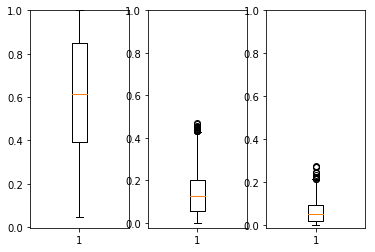

In [249]:
plt.subplot(1, 3, 1)
plt.boxplot(images_df[images_df.p1_dog == True].p1_conf)
plt.ylim(ymax=1)

plt.subplot(1, 3, 2)
plt.boxplot(images_df[images_df.p2_dog == True].p2_conf)
plt.ylim(ymax=1)

plt.subplot(1, 3, 3)
plt.boxplot(images_df[images_df.p3_dog == True].p3_conf)
plt.ylim(ymax=1)

plt.show()

The highest confindence predictions come from Prediction 1.

## Cleaning and Tidying Data
- Low quality (dirty) data has content issues. Fix 8 of these.
- Untidy (messy) data has structural issues. Fix 2 of these.

#### Remove Extra Archive Columns
Remove columns with data unnecessary for analysis.

In [184]:
archive_df.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id',
                         'source', 'retweeted_status_user_id',
                         'retweeted_status_timestamp'], inplace=True, errors='ignore')

#### Remove Extra Tweet Download Columns
Remove all columns except those needed for analysis.

In [191]:
tweets_df = tweets_df[['id_str', 'retweet_count', 'favorite_count']].set_index('id_str')

#### There Aren't Even Dogs in These (Remove Tweets without Dogs)
Some tweets had no dogs in them or they weren't specifically about the dog; remove these.

In [132]:
r_col = ['835152434251116546', '746906459439529985', '670842764863651840', '855862651834028034']
archive_df.drop(index=r_col, inplace=True)

#### Remove Retweets and Tweets with No Photos
We love them all, but we want to see original tweets with photos.

In [126]:
archive_df = archive_df[archive_df.retweeted_status_id.isna() &
                        ~archive_df.expanded_urls.isna()]
len(archive_df)

2114

After removal of retweets and tweets without photos, 2114 tweets remain.

#### DoggoLingo (Tidy Structure)
Combine *doggo, floofer, pupper,* and *puppo* columns in to a single *doggolingo* variable.

In [138]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']
archive_df[cols] = archive_df[cols].replace('None', '')
archive_df['doggolingo'] = archive_df[cols].apply(lambda x: ';'.join(filter(None, x)), axis=1)

archive_df.drop(cols, axis='columns', inplace=True, errors='ignore')

#### A Dog Named None (Correct Names)

For names that are 'None' or all lower case, convert them to blanks.

In [ ]:
archive_df.loc[(archive_df.name=='None') |
               (archive_df.name.str.islower()), 'name'] = ''

#### They're Good Dogs (Correct Ratings)
Update ratings that were found with incorrect denominators.

In [114]:
update_ratings = pd.DataFrame([
    {'tweet_id': '835246439529840640', 'rating_numerator': 13, 'rating_denominator': 10},
    {'tweet_id': '832088576586297345', 'rating_numerator': pd.np.nan, 'rating_denominator': pd.np.nan},
    {'tweet_id': '810984652412424192', 'rating_numerator': pd.np.nan, 'rating_denominator': pd.np.nan},
    {'tweet_id': '775096608509886464', 'rating_numerator': 14, 'rating_denominator': 10},
    {'tweet_id': '740373189193256964', 'rating_numerator': 14, 'rating_denominator': 10},
    {'tweet_id': '682962037429899265', 'rating_numerator': 10, 'rating_denominator': 10},
    {'tweet_id': '682808988178739200', 'rating_numerator': pd.np.nan, 'rating_denominator': pd.np.nan},
    {'tweet_id': '666287406224695296', 'rating_numerator': 9, 'rating_denominator': 10}
]).set_index('tweet_id')

archive_df.update(update_ratings, overwrite=True)

#### Award for the Most Confident Dog
Select the prediction that is a dog and is the most confident about dog type as the ultimate prediction.

In [314]:
# create three temporary DataFrames of info, rename columns to append all stacked
images_p1_df = images_df.reset_index()[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog']]
images_p2_df = images_df.reset_index()[['tweet_id', 'jpg_url', 'img_num', 'p2', 'p2_conf', 'p2_dog']]
images_p3_df = images_df.reset_index()[['tweet_id', 'jpg_url', 'img_num', 'p3', 'p3_conf', 'p3_dog']]

images_p1_df.rename(columns={'p1': 'object', 'p1_conf': 'conf', 'p1_dog': 'is_dog'}, inplace=True)
images_p2_df.rename(columns={'p2': 'object', 'p2_conf': 'conf', 'p2_dog': 'is_dog'}, inplace=True)
images_p3_df.rename(columns={'p3': 'object', 'p3_conf': 'conf', 'p3_dog': 'is_dog'}, inplace=True)

a = pd.DataFrame()
a = (a.append(images_p1_df)
      .append(images_p2_df)
      .append(images_p3_df)
    )

# Select only 'dog' images, then keep only the highest confidence dog image
# reset index and massage DataFrame for later use
images_df = (a[a.is_dog==True]
              .groupby(['tweet_id', 'jpg_url', 'img_num'])
              .apply(lambda x: x[x.conf==x.conf.max()])
              .drop(columns=['tweet_id', 'jpg_url', 'img_num'])
              .reset_index()
              .set_index('tweet_id')
              .drop(columns=['level_3'])
            )

#### Join Tables
Join the information from the tweet details downloaded from Twitter and image predictions to the WeRateDogs Twitter archive.

In [251]:
master_df = archive_df.join(tweets_df)
master_df = master_df.join(images_df)

In [228]:
master_df[master_df.img_num.isnull()]

,timestamp,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,,,,,,,
886267009285017600,2017-07-15 16:51:35,@NonWhiteHat @MayhewMayhem...,NaN,NaN,12,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886054160059072513,2017-07-15 02:45:48,RT @Athletics: 12/10 #BATP...,8.860537344211026e+17,https://twitter.com/dog_ra...,12,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
885518971528720385,2017-07-13 15:19:09,I have a new hero and his ...,NaN,https://twitter.com/4bonds...,14,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
884247878851493888,2017-07-10 03:08:17,OMG HE DIDN'T MEAN TO HE W...,NaN,https://twitter.com/kaijoh...,13,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881633300179243008,2017-07-02 21:58:53,@roushfenway These are goo...,NaN,NaN,17,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879674319642796034,2017-06-27 12:14:36,@RealKentMurphy 14/10 conf...,NaN,NaN,14,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879130579576475649,2017-06-26 00:13:58,RT @dog_rates: This is Emm...,8.780576130401157e+17,https://twitter.com/dog_ra...,14,10,Emmy,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878604707211726852,2017-06-24 13:24:20,Martha is stunning how h*c...,NaN,https://twitter.com/bbcwor...,13,10,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878404777348136964,2017-06-24 00:09:53,RT @dog_rates: Meet Shadow...,8.782815110064783e+17,https://www.gofundme.com/3...,13,10,Shadow,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Store Twitter Archive Master
Store the final cleaned archive according to project requirements.

*Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately.*